In [253]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta


batchA = pd.read_csv('batchA.csv').T
batchB = pd.read_csv('batchB.csv').T
batchA['batch'] = '1'
batchB['batch'] = '2'
allBatch = pd.read_csv('allBatch.csv', index_col=0).T
allBatch.reset_index(drop=False, inplace=True)
allBatch = allBatch.rename_axis(None, axis=1)
allBatch = allBatch.rename(columns={'index': 'Pre-wetting date'})

# cleaning columns
dateColumns = allBatch.columns[0:2]
percentColumns = allBatch.columns[[4, 5, 8, 11, 12]]
numericalCols = allBatch.columns[2:18]
allBatch[percentColumns] = allBatch[percentColumns].apply(lambda x : x.str.strip('%').astype(float)/100)
allBatch[numericalCols] = allBatch[numericalCols].applymap(lambda x: re.sub("[^0-9]", "", x) if type(x) == str else x)
allBatch[numericalCols] = allBatch[numericalCols].apply(pd.to_numeric, errors='coerce', downcast='float')
allBatch['Pre-wetting date'] = pd.to_datetime(allBatch['Pre-wetting date'], format="%d-%b-%y", errors='coerce')
allBatch['Evacuation date (B)'] = pd.to_datetime(allBatch['Evacuation date (B)'], format="%d-%b-%y", errors='coerce')
allBatch = allBatch[~allBatch['Kg/bag (White & Brown)'].isna()]



In [258]:
def column_imputer(df, cols_to_fill):
    df['Pre-wetting date'] = df['Pre-wetting date'].fillna(df['Evacuation date (B)'] - timedelta(14))
    diff_we = (df['Pre-wetting date'] - df['Evacuation date (B)']).mean()
    df['Evacuation date (B)'] = df['Evacuation date (B)'].fillna(df['Pre-wetting date'] - diff_we)
    mean = df[cols_to_fill].mean()
    df[cols_to_fill] = df[cols_to_fill].fillna(mean)
    return df

allBatch = column_imputer(allBatch, numericalCols)

In [260]:
def _dateEncode(X):
    #cyclical encoding of dates
    X = X.copy()
    year_norm = 2 * np.pi * X['Pre-wetting date'].dt.year / X['Pre-wetting date'].dt.year.max()
    month_norm = 2 * np.pi * X['Pre-wetting date'].dt.month / X['Pre-wetting date'].dt.month.max()
    day_norm = 2 * np.pi * X['Pre-wetting date'].dt.day / X['Pre-wetting date'].dt.day.max()
    #weekday_norm = 2 * np.pi * X['Pre-wetting date'].dt.weekday / X['Pre-wetting date'].dt.weekday.max()
    #hour_norm = 2 * np.pi * X['Pre-wetting date'].dt.hour / X['Pre-wetting date'].dt.hour.max()
    X.loc[:, 'year_sin'] = np.sin(year_norm)
    X.loc[:, 'year_cos'] = np.cos(year_norm)
    X.loc[:, 'month_sin'] = np.sin(month_norm)
    X.loc[:, 'month_cos'] = np.cos(month_norm)
    X.loc[:, 'day_sin'] = np.sin(day_norm)
    X.loc[:, 'day_cos'] = np.cos(day_norm)
    #X.loc[:, 'weekday_sin'] = np.sin(weekday_norm)
    #X.loc[:, 'weekday_cos'] = np.cos(weekday_norm)
    #X.loc[:, 'hour_sin'] = np.sin(hour_norm)
    #X.loc[:, 'hour_cos'] = np.cos(hour_norm)
    #encode dates
    X.loc[:, 'year'] = X['Pre-wetting date'].dt.year
    X.loc[:, 'month'] = X['Pre-wetting date'].dt.month
    X.loc[:, 'day'] = X['Pre-wetting date'].dt.day
    #X.loc[:, 'weekday'] = X['Pre-wetting date'].dt.weekday
    #X.loc[:, 'hour'] = X['Pre-wetting date'].dt.hour
    #X.loc[:, 'workday'] = np.where(X['weekday'].isin([0,4]), 1,0)
    return X

In [263]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer



allBatch = _dateEncode(allBatch)


y = allBatch['Kg/bag (White & Brown)']
X = allBatch.drop(columns='Kg/bag (White & Brown)')
X = X[X.columns[2:26]]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

date_encoder = FunctionTransformer(_dateEncode)
dateCols = ['day', 'month']

preprocessor = ColumnTransformer(
        [
            ('dateEncode', 'passthrough', dateCols),
            ('imputer', 'passthrough', X.columns[2:7]),
        ]
)

regressor = ExtraTreesRegressor(random_state=42)
pipe = make_pipeline(preprocessor, regressor)

pipe.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('dateEncode', 'passthrough',
                                                  ['day', 'month']),
                                                 ('imputer', 'passthrough',
                                                  Index(['Moisture content PII', 'Conversion rate', 'Fill bag rate',
       'Spawn rate (ml)', 'Compost score'],
      dtype='object'))])),
                ('extratreesregressor', ExtraTreesRegressor(random_state=42))])

In [264]:
from sklearn.metrics import mean_squared_error
yhat = pipe.predict(X_test)
print("Mean squared error: {}".format(mean_squared_error(yhat, y_test)))
(yhat, y_test)

Mean squared error: 19.458028571428567


(array([13.84,  6.35, 17.71, 23.97, 25.78, 17.28, 11.05, 22.25, 26.42,
        22.89, 22.79, 24.48, 10.83, 23.66]),
 130    14.0
 66      7.0
 107    27.0
 19     22.0
 42     29.0
 60     13.0
 12     14.0
 112    17.0
 103    24.0
 104    24.0
 44     26.0
 40     33.0
 27     16.0
 47     24.0
 Name: Kg/bag (White & Brown), dtype: float32)

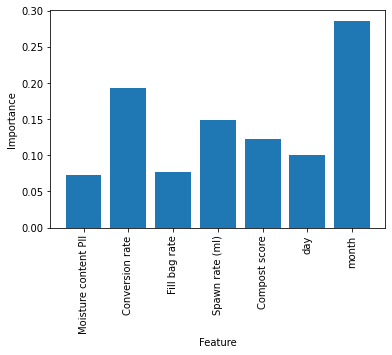

In [265]:
inputCols = X.columns[2:7].tolist() + dateCols
plt.bar(range(len(inputCols)), pipe.named_steps['extratreesregressor'].feature_importances_)
plt.xticks(range(len(inputCols)), inputCols, rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

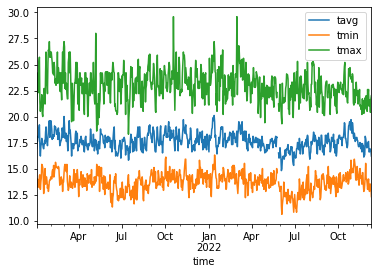

In [266]:
# add weather variables to the data:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

start = allBatch['Pre-wetting date'].min()
end = allBatch['Evacuation date (B)'].max()

# Create Point for Musanze, Rwanda
location = Point(-1.49984, 29.63497, 1850)

# Get daily data for 2018
data = Daily(location, start, end)
weatherData = data.fetch()

# Plot line chart including average, minimum and maximum temperature
weatherData.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()


In [299]:
arr = pd.DataFrame()
arr[0] = (weatherData.loc['2021-01-02':'2021-01-06', :].mean()).T

In [335]:
arr = pd.DataFrame(columns=weatherData.columns)
for i in allBatch.index:
    startDate = allBatch.loc[i, 'Pre-wetting date']
    endDate = allBatch.loc[i, 'Evacuation date (B)']
    arr.loc[i] = weatherData.loc[startDate:endDate, :].mean()

In [340]:
df_new = pd.concat([allBatch, arr], axis=1)

In [341]:
df_new

,Pre-wetting date,Evacuation date (B),Wet straw at lay-out (T),Dry straw at lay-out (T),Moisture content PII,Conversion rate,Fill bag rate,Spawn rate (ml),Compost score,# bags (WHITE),...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2017-12-30,2018-03-25 00:00:00.000000000,106.0,903.0,0.70,0.56,16.0,120.0,0.713982,745.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-13,2018-04-08 00:00:00.000000000,120.0,1020.0,0.70,0.61,15.0,126.0,0.713982,1123.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-27,2018-05-01 00:00:00.000000000,140.0,1232.0,0.73,0.83,145.0,130.0,0.713982,2255.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-02-10,2018-05-11 00:00:00.000000000,142.0,1250.0,0.71,0.75,15.0,124.0,0.713982,1930.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-02-24,2018-05-29 00:00:00.000000000,142.0,1250.0,0.70,0.80,15.0,128.0,0.713982,1983.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2022-07-18,2022-10-26 00:00:00.000000000,180.0,1440.0,0.70,0.78,145.0,125.0,0.760000,2205.0,...,17.582178,13.533663,22.612871,1.857426,NaN,213.227723,5.824752,NaN,1016.369307,NaN
133,2022-08-01,2022-11-10 00:00:00.000000000,205.0,1640.0,0.71,0.68,15.0,125.0,0.780000,2246.0,...,17.728431,13.785294,22.588235,2.092157,NaN,207.284314,5.708824,NaN,1016.169608,NaN
134,2022-08-15,2022-11-26 00:00:00.000000000,205.0,1640.0,0.68,0.77,145.0,125.0,0.800000,2420.0,...,17.663462,13.920192,22.292308,2.702885,NaN,207.461538,5.438462,NaN,1016.152885,NaN
135,2022-08-29,2022-12-09 00:00:00.000000000,205.0,1743.0,0.68,0.66,145.0,125.0,0.713982,2181.0,...,17.637864,13.952427,22.192233,2.906796,NaN,214.796117,5.348544,NaN,1015.930097,NaN
